# PREPROCESSING PROCESS EXPLAINATION

IMPORT REQUIRED LIBRABRY

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import rank
from skimage.morphology import disk
from skimage.transform import rotate
from tqdm import tqdm
from pathlib import Path

IMG_SIZE = (256, 256)
IMAGE_COLUMNS= 4
IMAGE_ROWS = 1


def display_img(image_sample, classes):
    
    # Create a row of subplots with equal sizes
    fig, axes = plt.subplots(IMAGE_ROWS, IMAGE_COLUMNS, figsize=(10, 10))  

    # If only one image, axes is not iterable, so we convert it into a list
    if len(image_sample) == 1:
        axes = [axes]

    axes = axes.flatten()


    # Display images in a row
    for i, data in enumerate(image_sample):
        axes[i].imshow(data, cmap='gray')  # Show the image in grayscale
        axes[i].axis('off')  # Hide the axes
        axes[i].set_title(f"{classes[i]}")  # Title for each image

    for j in range(len(image_sample), 4):
        axes[j].axis('off')

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show() # Show the plot


IMAGE SAMPLE PREPARE

In [1]:
cur_path = os.path.dirname(os.getcwd())
data_path = os.path.join(cur_path, 'dataset/raw/training')
image_sample = []

classes = os.listdir(data_path)

# Take one image for each class to display
for c, label in enumerate(classes):
    class_path = os.path.join(data_path, label)
    img_file = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_file)
    img = cv2.imread(img_path)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_sample.append(img)

print("Sample images")
display_img(image_sample, classes)
    


NameError: name 'os' is not defined

FIRST FUNCTION: REMOVE BLACK EDGES

In [ ]:
def cut_to_edge(img):
    """Crop the image to remove black edges."""

    _, thresh = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img = img[y:y+h, x:x+w]

    return img

Before cut to edge


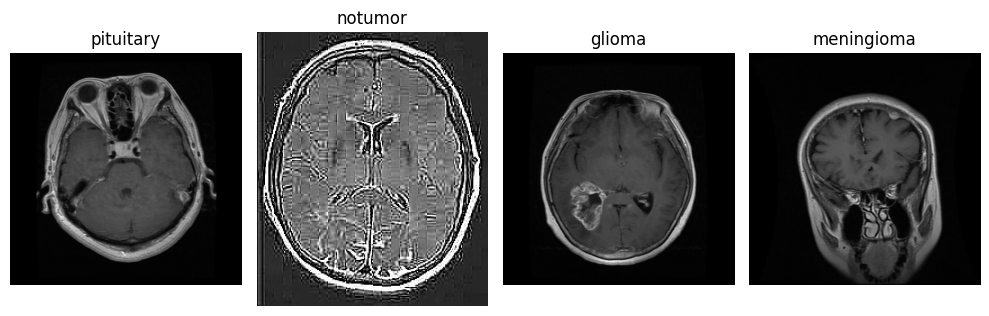

After cut to edge


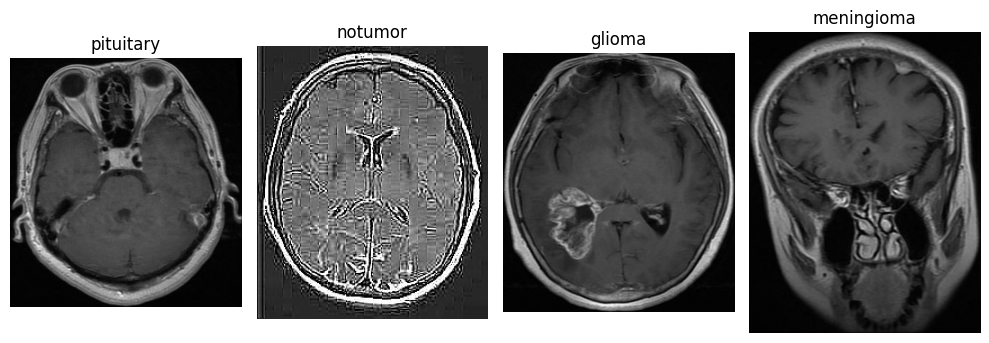

In [ ]:
print('Before cut to edge')
display_img(image_sample, classes)
after_cut_to_edge = [cut_to_edge(img) for img in image_sample]
print('After cut to edge')
display_img(after_cut_to_edge, classes)

SECOND FUNCTION: SKULL STRIPPING BY APPLYING MASK

In [ ]:
def apply_mask(img):
    """Apply a mask to extract the brain region (skull stripping)."""
    thresh = rank.otsu(img, disk(5))  # Otsu thresholding
    mask = thresh > 0
    img[~mask] = 0
    return img

Before mask


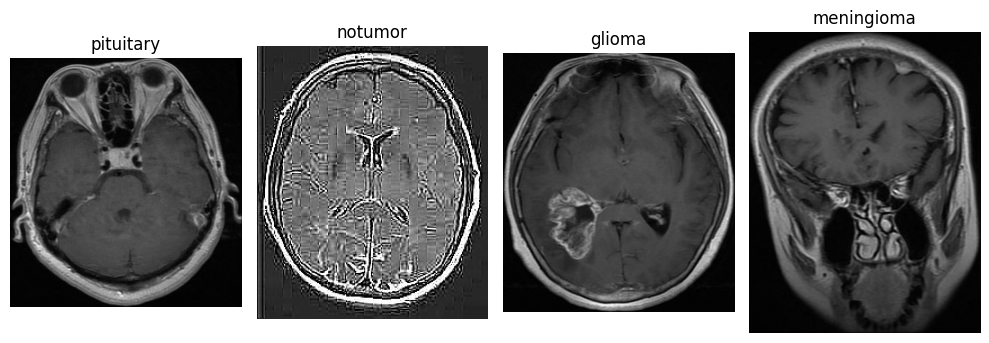

After mask


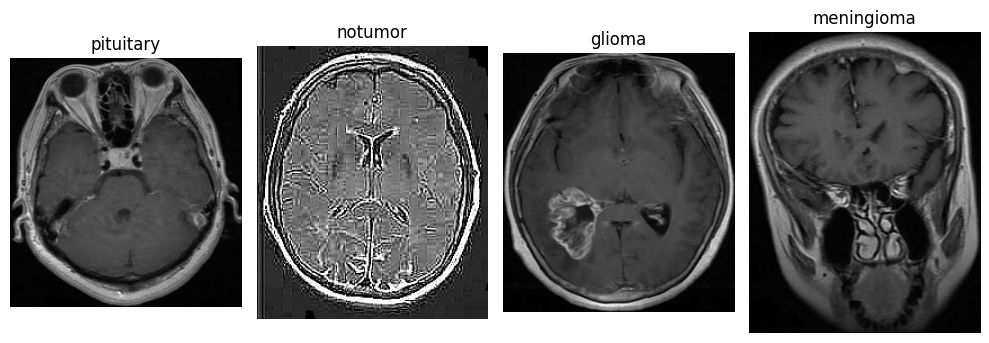

In [ ]:
print('Before mask')
display_img(after_cut_to_edge, classes)
after_mask = [apply_mask(img) for img in after_cut_to_edge]
print('After mask')
display_img(after_mask, classes)

THIRD FUNCTION: APPLY RANDOM ROTATION AND FLIPPING FOR TRAINING

In [ ]:
def augment_image(img):
    """Apply random rotation and flipping (only for training)."""
    angle = np.random.uniform(-15, 15)  # Random rotation between -15 and 15 degrees
    img = rotate(img, angle, resize=False, mode="edge")
    if np.random.rand() > 0.5:
        img = np.fliplr(img)  # Random horizontal flip
    return img

Before augmentation


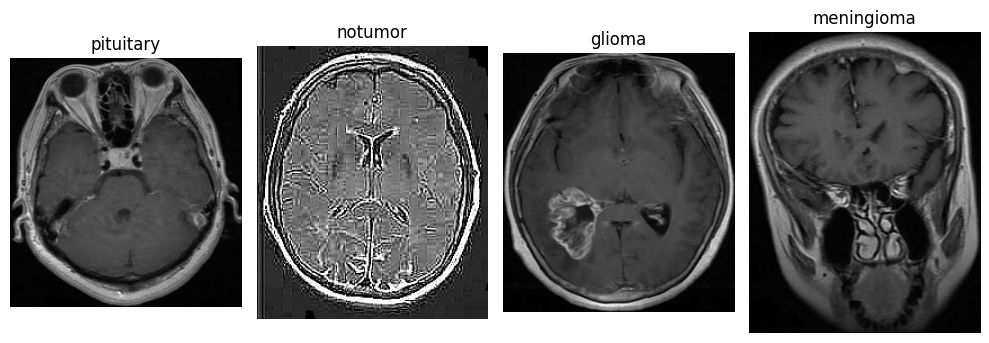

After augmentation


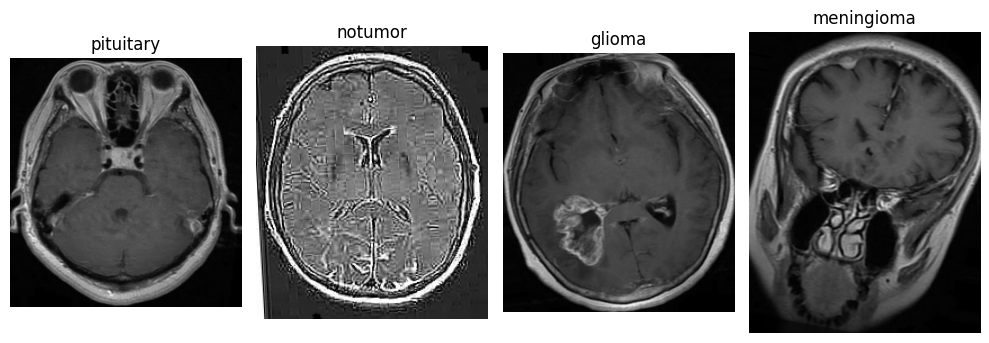

In [ ]:
print('Before augmentation')
display_img(after_mask, classes)
augmented_images = [augment_image(img) for img in after_mask]
print('After augmentation')
display_img(augmented_images, classes)

FOURTH FUNCTION: A PIPLINE COMBINES THREE MENTIONED FUNCTIONS AND NOMRALIZES IMAGES IN SIZE

In [ ]:
def preprocess_mri(img):
    """Preprocess the image for Decision Tree or PyTorch"""
    # if (img.shape[-1] == 3):
    #     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cut_to_edge(img)      
    img = apply_mask(img)       
    img = augment_image(img)
    img = cv2.resize(img, IMG_SIZE) 
    img = img / 255.0          
    return img

Before preprocessing


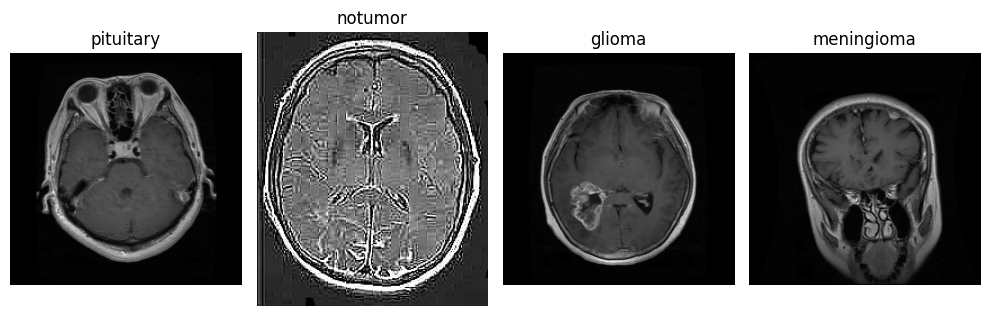

After preprocessing


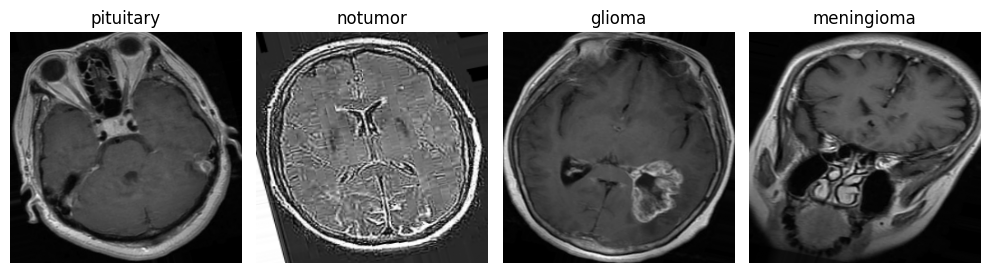

In [ ]:
print('Before preprocessing')
display_img(image_sample, classes)
preprocessed_images = [preprocess_mri(img) for img in image_sample]
print('After preprocessing')
display_img(preprocessed_images, classes)